## Import Libraries

In [1]:
from glob import glob
from scipy.io import wavfile
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch 
import tensorflow as tf
from python_speech_features import mfcc, logfbank
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## Define Paths

In [2]:
real_audio = glob("/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/*")
fake_audio = glob("/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/*")

real_audio.sort()
fake_audio.sort()

data=[]

for i, path in enumerate(real_audio):
    filename = path.replace("/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/", "")
    data.append((i, filename, "Real"))

# Process fake audio files
for i, path in enumerate(fake_audio):
    filename = path.replace("/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/", "")
    data.append((i, filename, "Fake"))

## Read Audio and Label Distribution

In [3]:
speech_df = pd.DataFrame(data, columns=["index", "Filename", "Label"])

speech_df

,index,Filename,Label
0,0,biden-original.wav,Real
1,1,linus-original.wav,Real
2,2,margot-original.wav,Real
3,3,musk-original.wav,Real
4,4,obama-original.wav,Real
...,...,...,...
59,51,trump-to-linus.wav,Fake
60,52,trump-to-margot.wav,Fake
61,53,trump-to-musk.wav,Fake
62,54,trump-to-ryan.wav,Fake


In [4]:
speech_df['Label'].value_counts()

Label
Fake    56
Real     8
Name: count, dtype: int64

In [5]:
durations = []

for f in speech_df.index:
    filename = speech_df.loc[f, 'Filename']
    if speech_df.loc[f, 'Label'] == 'Real':
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/{filename}"
    else:
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/{filename}"
    
    rate, signal = wavfile.read(file_path)
    
    duration_seconds = len(signal) / rate
    
    duration_minutes = duration_seconds / 60
    
    durations.append(duration_minutes)

speech_df['duration_minutes'] = durations

speech_df


/var/folders/5s/1w6_qpg97r5fkn483pgyr4540000gn/T/ipykernel_1372/1918372798.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read(file_path)


,index,Filename,Label,duration_minutes
0,0,biden-original.wav,Real,10.000050
1,1,linus-original.wav,Real,9.505959
2,2,margot-original.wav,Real,1.324786
3,3,musk-original.wav,Real,10.002229
4,4,obama-original.wav,Real,10.007489
...,...,...,...,...
59,51,trump-to-linus.wav,Fake,10.000000
60,52,trump-to-margot.wav,Fake,10.000000
61,53,trump-to-musk.wav,Fake,10.000000
62,54,trump-to-ryan.wav,Fake,10.000000


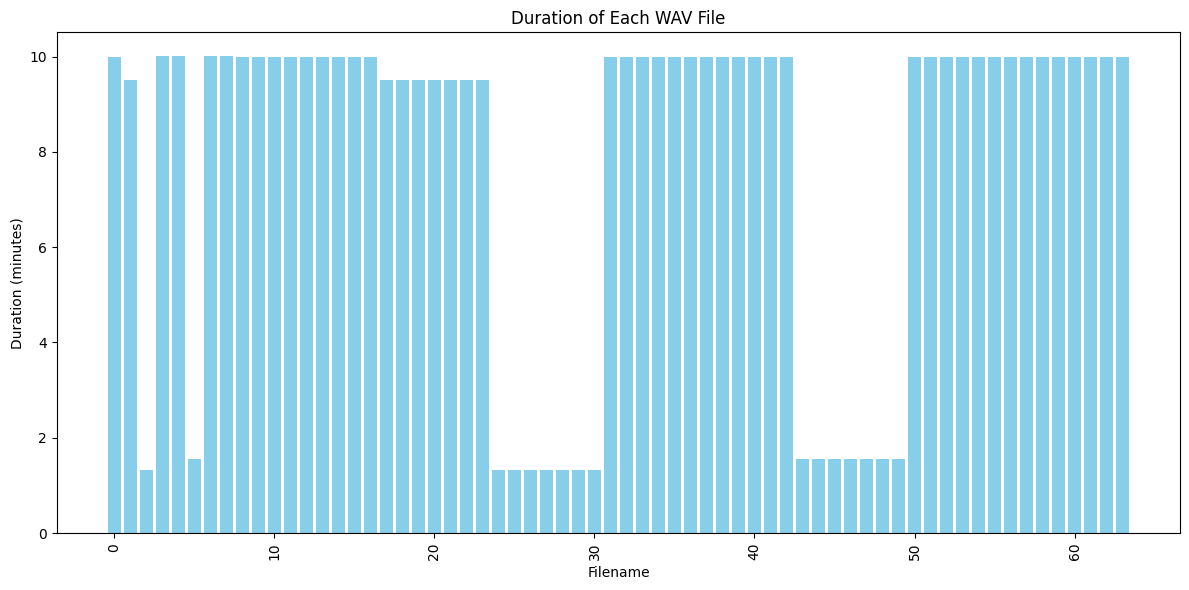

In [6]:
plt.figure(figsize=(12, 6))
plt.bar(speech_df.index, speech_df['duration_minutes'], color='skyblue')
plt.xlabel('Filename')
plt.ylabel('Duration (minutes)')
plt.title('Duration of Each WAV File')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything

# Show the plot
plt.show()

/var/folders/5s/1w6_qpg97r5fkn483pgyr4540000gn/T/ipykernel_1372/3609121890.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(speech_df.index, rotation=90)
/var/folders/5s/1w6_qpg97r5fkn483pgyr4540000gn/T/ipykernel_1372/3609121890.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


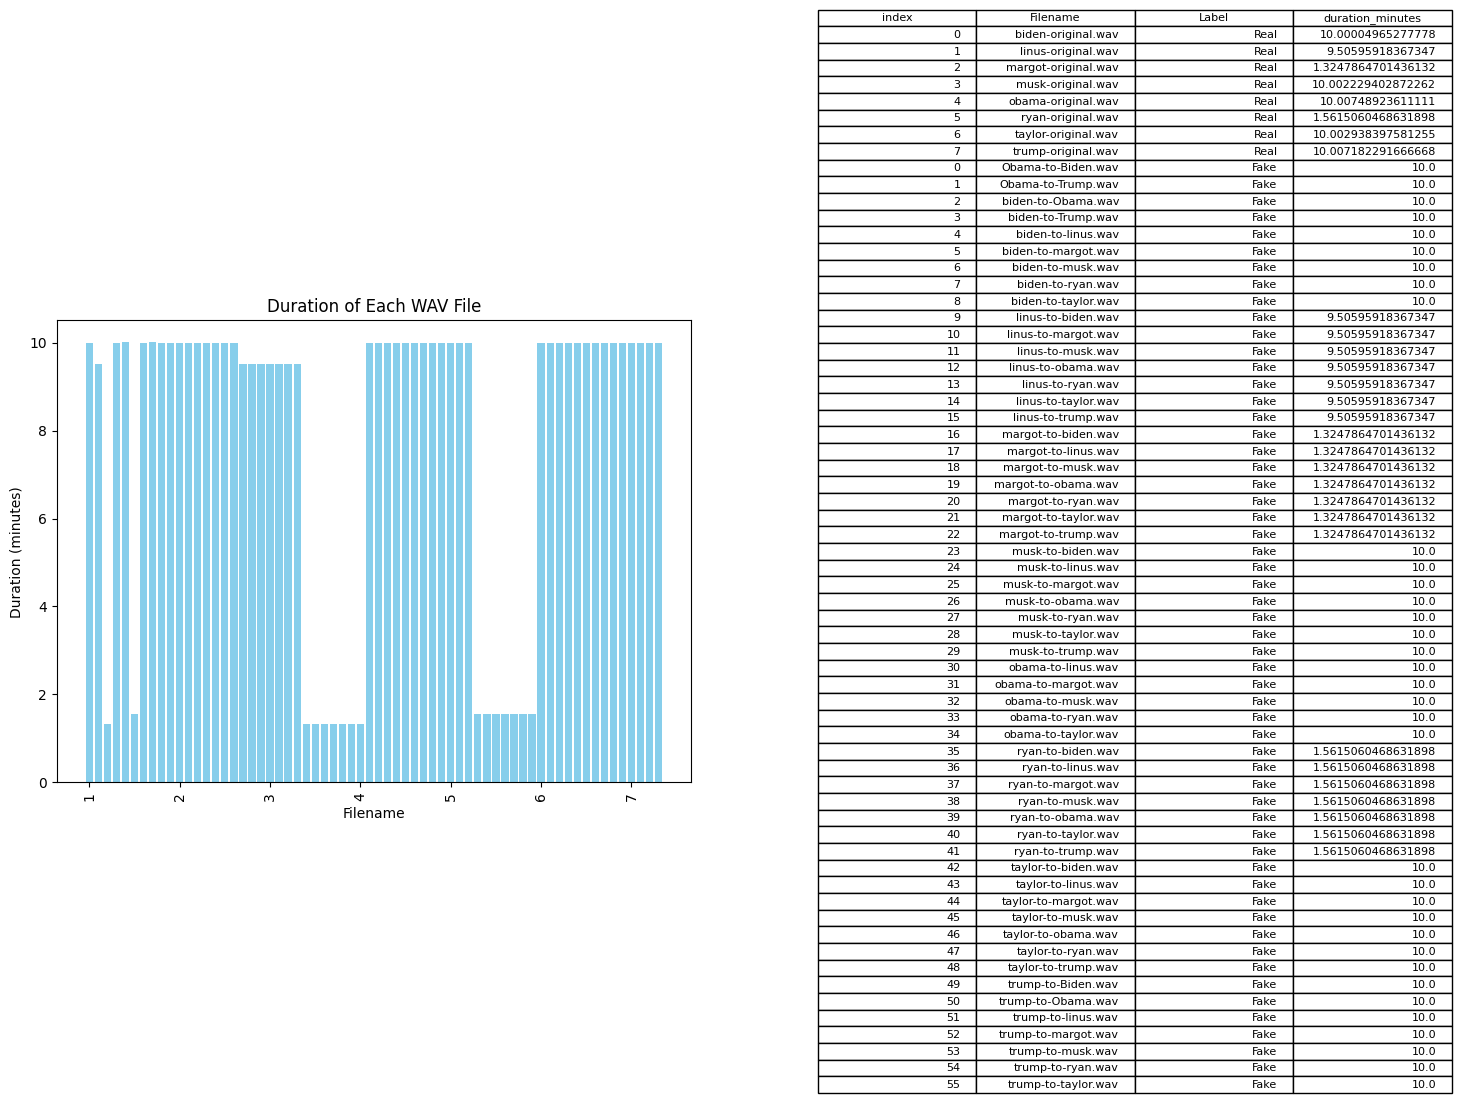

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.bar(speech_df.index, speech_df['duration_minutes'], color='skyblue')
ax1.set_xlabel('Filename')
ax1.set_ylabel('Duration (minutes)')
ax1.set_title('Duration of Each WAV File')
ax1.set_xticklabels(speech_df.index, rotation=90) 

ax2.axis('off')
ax2.table(cellText=speech_df.values, colLabels=speech_df.columns, loc='center')

plt.tight_layout()

plt.show()

## Exploratory Data Analysis and Data Cleaning

### Before Cleaning

Label: Fake, Filename: Obama-to-Biden.wav, File path: /Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav
Label: Real, Filename: biden-original.wav, File path: /Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/biden-original.wav
Signals dictionary: {'Fake': array([ 0.00134889,  0.00059836,  0.00024294, ..., -0.00080377,
       -0.00119099, -0.00085708], dtype=float32), 'Real': array([ 2.9329121e-02,  3.6427513e-02,  3.5523672e-02, ...,
       -2.6930615e-04,  8.1658211e-05,  0.0000000e+00], dtype=float32)}
FFT dictionary: {'Fake': (array([2.97728858e-04, 2.95559660e-06, 1.79081046e-06, ...,
       3.13097345e-11, 2.99460807e-11, 2.82684701e-11]), array([0.00000000e+00, 1.66666667e-03, 3.33333333e-03, ...,
       2.20499967e+04, 2.20499983e+04, 2.20500000e+04])), 'Real': (array([1.13644920e-06, 5.98119868e-07, 3.07150260e-07, ...,
       2.23916910e-10, 2.25920202e-10, 2.26603424e-10]), array([0.00000000e+00, 1.66665835e-03, 3.33331670e-03, ...,
  

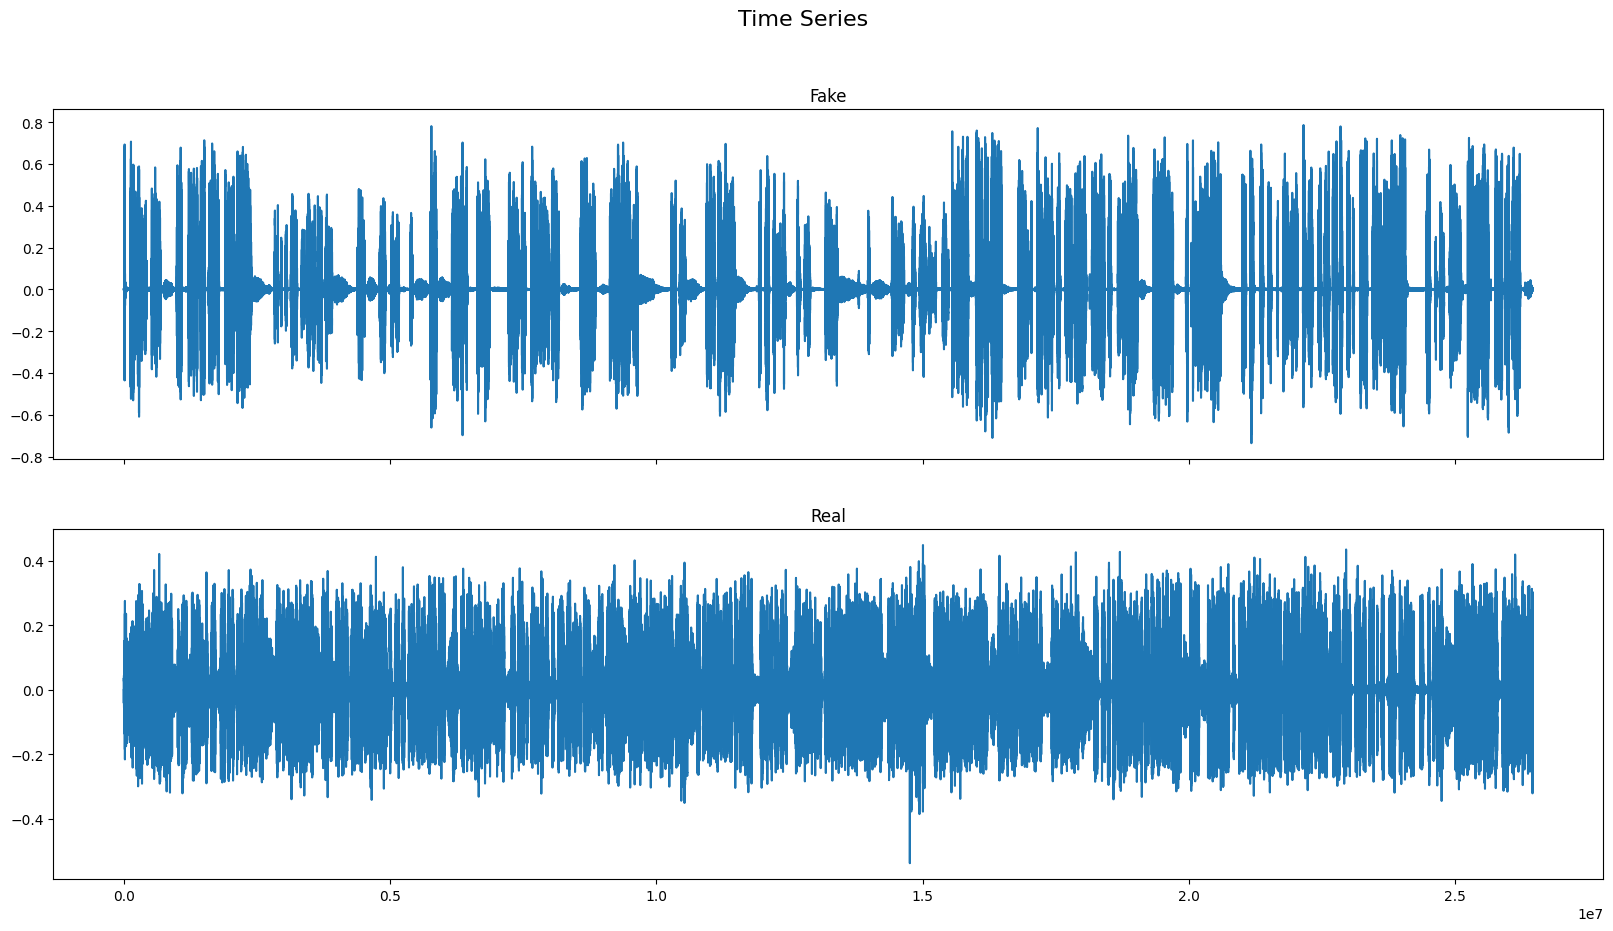

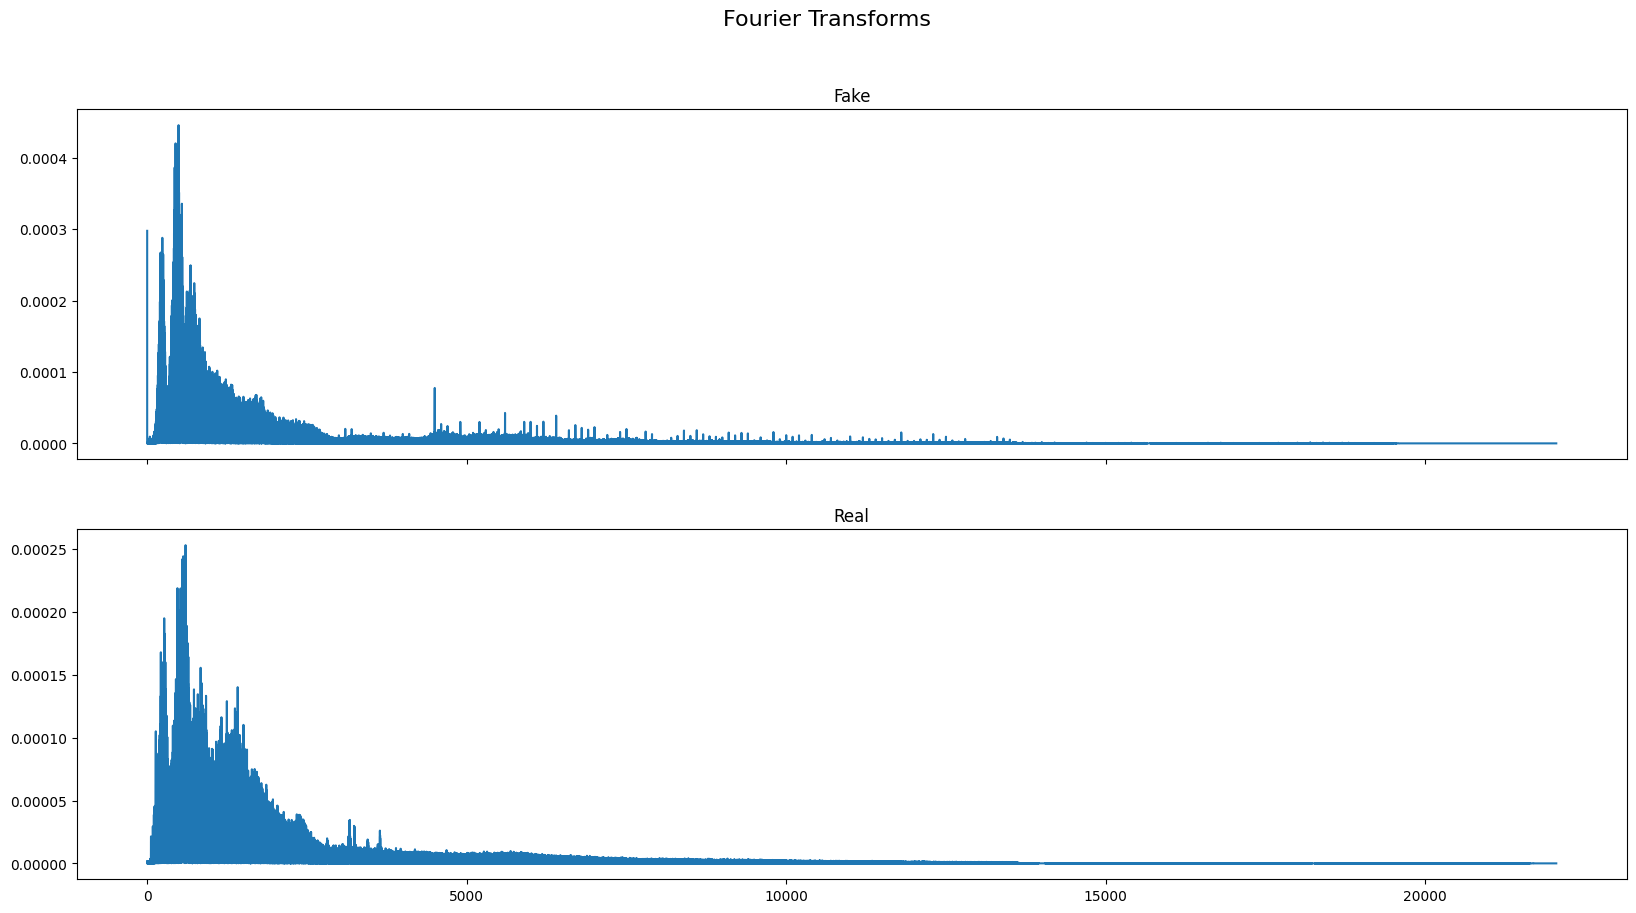

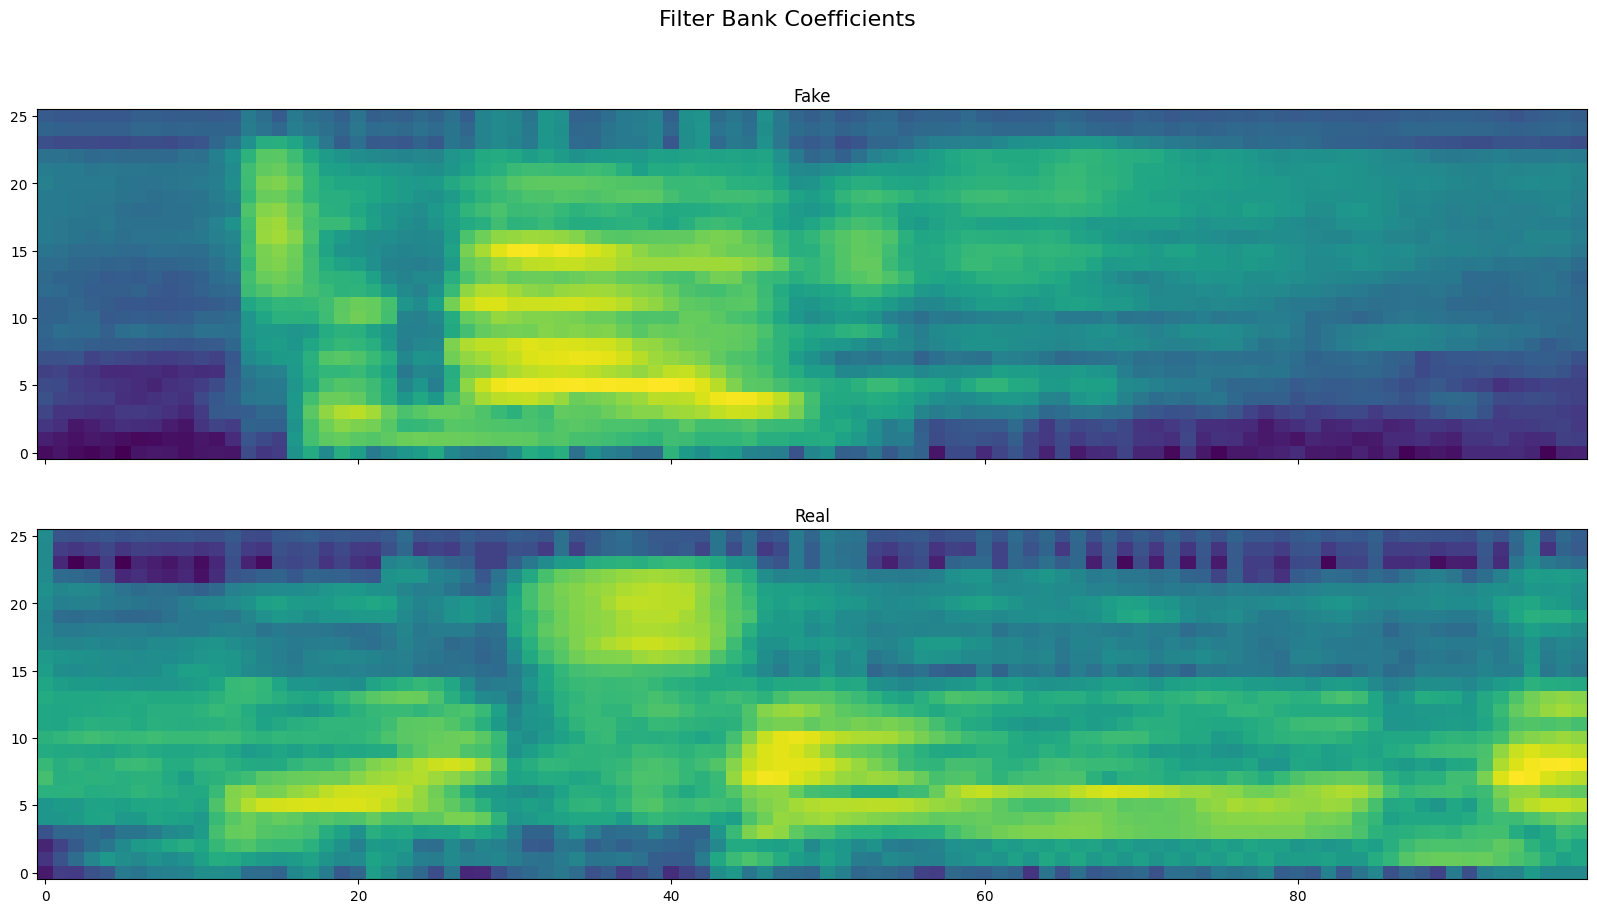

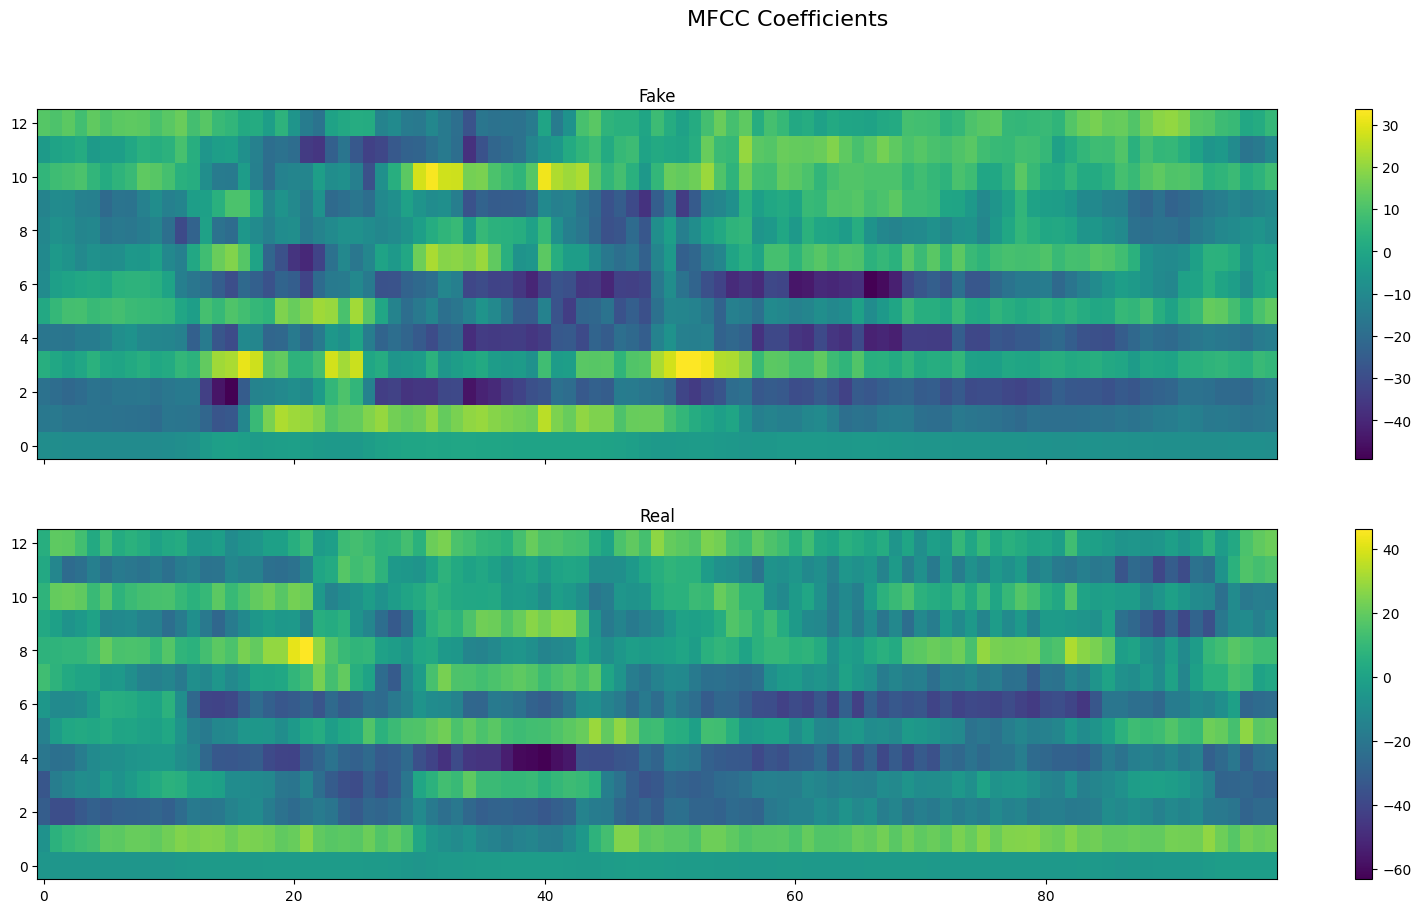

In [8]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y) / n)
    return (Y, freq)

def plot_signals(signals):
    if not signals:
        print("No signals to plot.")
        return
    fig, axes = plt.subplots(nrows=len(signals), ncols=1, figsize=(20, 10), sharex=True)
    fig.suptitle('Time Series', size=16)
    for i, (label, signal) in enumerate(signals.items()):
        axes[i].set_title(label)
        axes[i].plot(signal)
    plt.show()

def plot_fft(fft):
    if not fft:
        print("No FFT data to plot.")
        return
    fig, axes = plt.subplots(nrows=len(fft), ncols=1, figsize=(20, 10), sharex=True)
    fig.suptitle('Fourier Transforms', size=16)
    for i, (label, (Y, freq)) in enumerate(fft.items()):
        axes[i].set_title(label)
        axes[i].plot(freq, Y)
    plt.show()

def plot_fbank(fbank):
    if not fbank:
        print("No Filter Bank data to plot.")
        return
    fig, axes = plt.subplots(nrows=len(fbank), ncols=1, figsize=(20, 10), sharex=True)
    fig.suptitle('Filter Bank Coefficients', size=16)
    for i, (label, bank) in enumerate(fbank.items()):
        axes[i].set_title(label)
        axes[i].imshow(bank, aspect='auto', origin='lower')
    plt.show()

def plot_mfccs(mfccs):
    if not mfccs:
        print("No MFCC data to plot.")
        return
    fig, axes = plt.subplots(nrows=len(mfccs), ncols=1, figsize=(20, 10), sharex=True)
    fig.suptitle('MFCC Coefficients', size=16)
    for i, (label, mfcc) in enumerate(mfccs.items()):
        axes[i].set_title(label)
        im = axes[i].imshow(mfcc, aspect='auto', origin='lower')
        fig.colorbar(im, ax=axes[i])
    plt.show()


speech_df['Filename'] = speech_df['Filename'].astype(str)

classes = list(np.unique(speech_df['Label']))
class_dist = speech_df.groupby(['Label'])['duration_minutes'].mean()
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = speech_df[speech_df['Label'] == c].iloc[0]['Filename']
    
    if c == 'Real':
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/{wav_file}"
    else:
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/{wav_file}"
    
    print(f"Label: {c}, Filename: {wav_file}, File path: {file_path}")
    
    try:
        signal, rate = lb.load(file_path, sr=44100)
        signals[c] = signal
        fft[c] = calc_fft(signal, rate)

        bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
        fbank[c] = bank
        mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
        mfccs[c] = mel
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

print("Signals dictionary:", signals)
print("FFT dictionary:", fft)
print("Filter Bank dictionary:", fbank)
print('Mfccs dictionary:',mfccs)

plot_signals(signals)
plot_fft(fft)
plot_fbank(fbank)
plot_mfccs(mfccs)



### After Cleaning

Label: Fake, Filename: Obama-to-Biden.wav, File path: /Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav
Label: Real, Filename: biden-original.wav, File path: /Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/biden-original.wav
Signals dictionary: {'Fake': array([ 0.00134889,  0.00059836,  0.00024294, ..., -0.00080377,
       -0.00119099, -0.00085708], dtype=float32), 'Real': array([ 2.9329121e-02,  3.6427513e-02,  3.5523672e-02, ...,
       -2.6930615e-04,  8.1658211e-05,  0.0000000e+00], dtype=float32)}
FFT dictionary: {'Fake': (array([2.97811209e-04, 2.48774244e-06, 1.76039465e-06, ...,
       6.07432706e-11, 5.68266854e-10, 3.43078607e-10]), array([0.00000000e+00, 1.76964801e-03, 3.53929602e-03, ...,
       2.20499965e+04, 2.20499982e+04, 2.20500000e+04])), 'Real': (array([1.13644920e-06, 5.98119868e-07, 3.07150260e-07, ...,
       2.23916910e-10, 2.25920202e-10, 2.26603424e-10]), array([0.00000000e+00, 1.66665835e-03, 3.33331670e-03, ...,
  

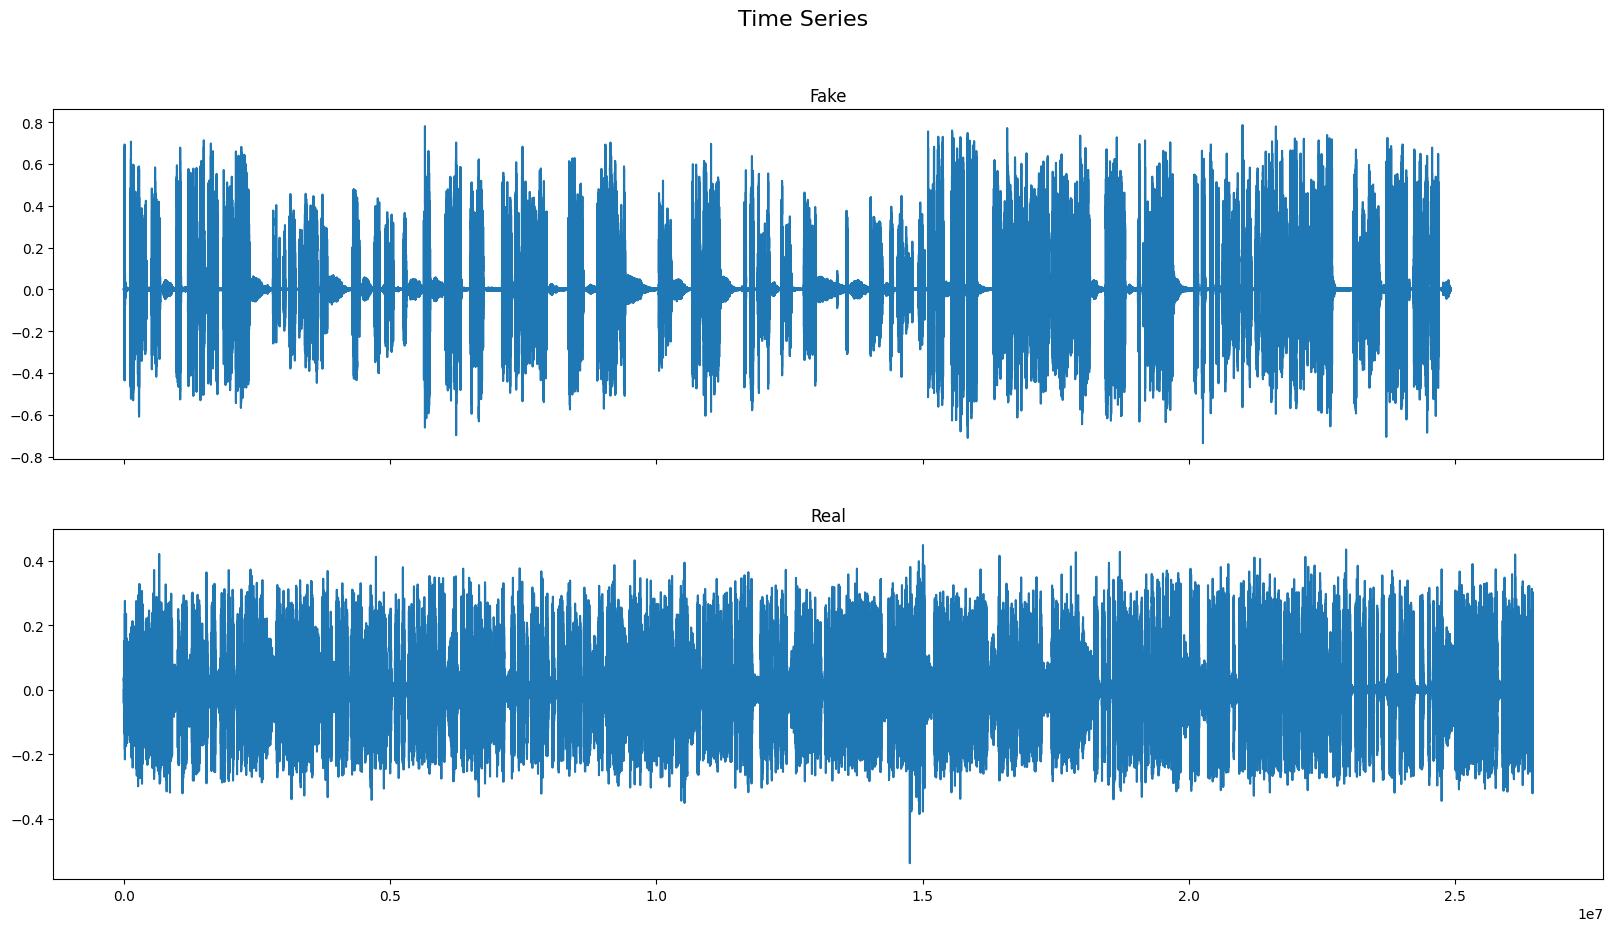

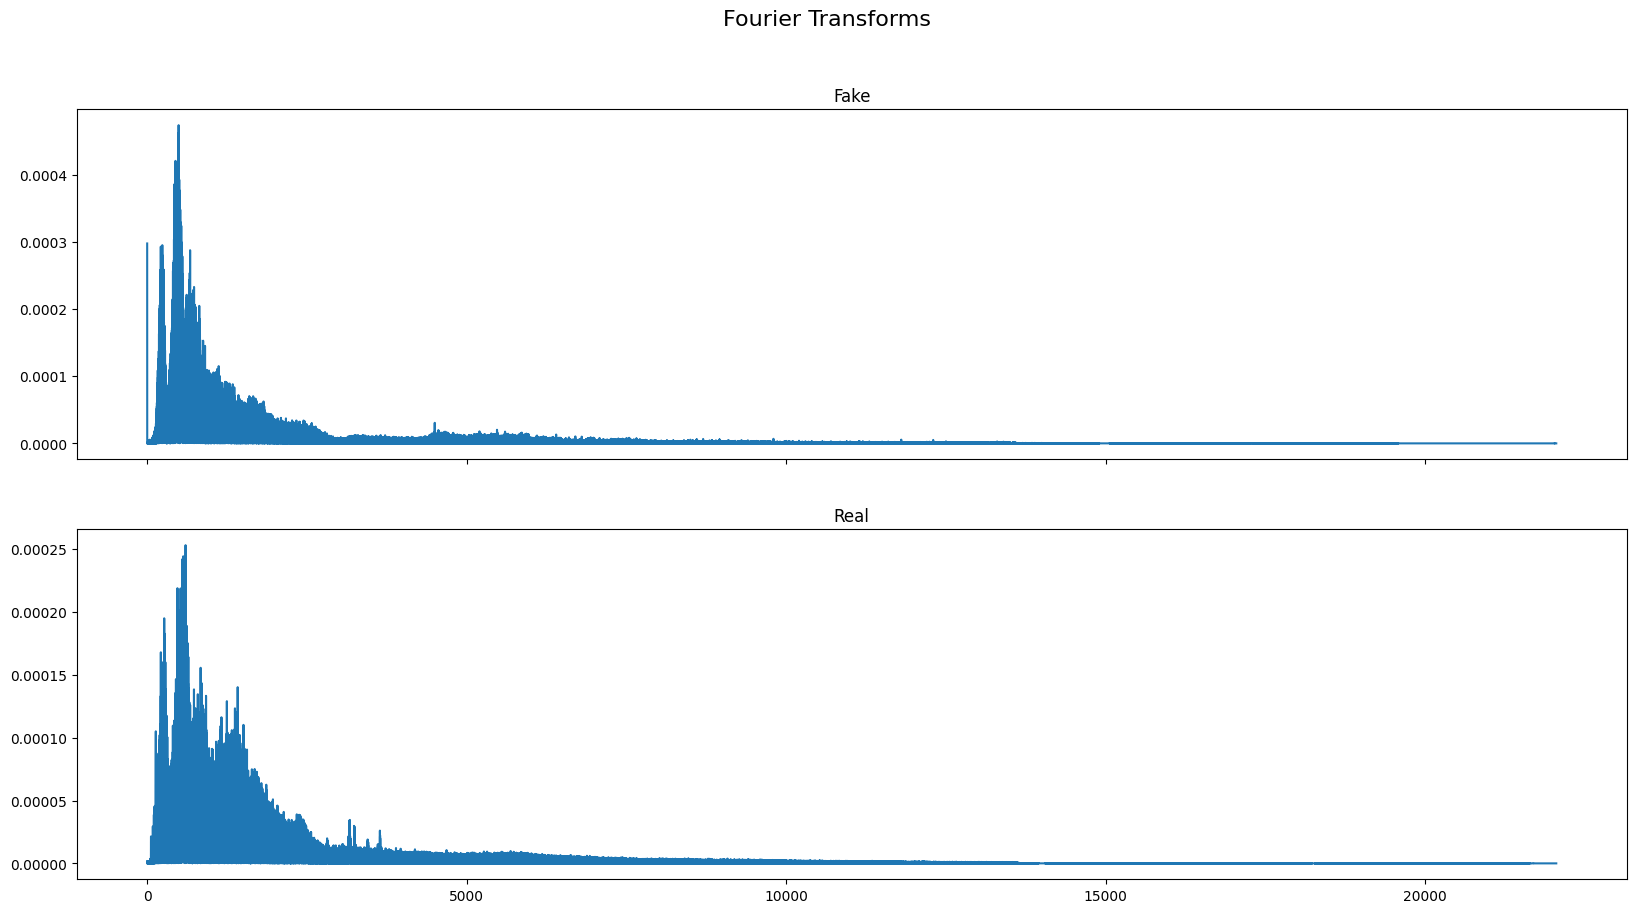

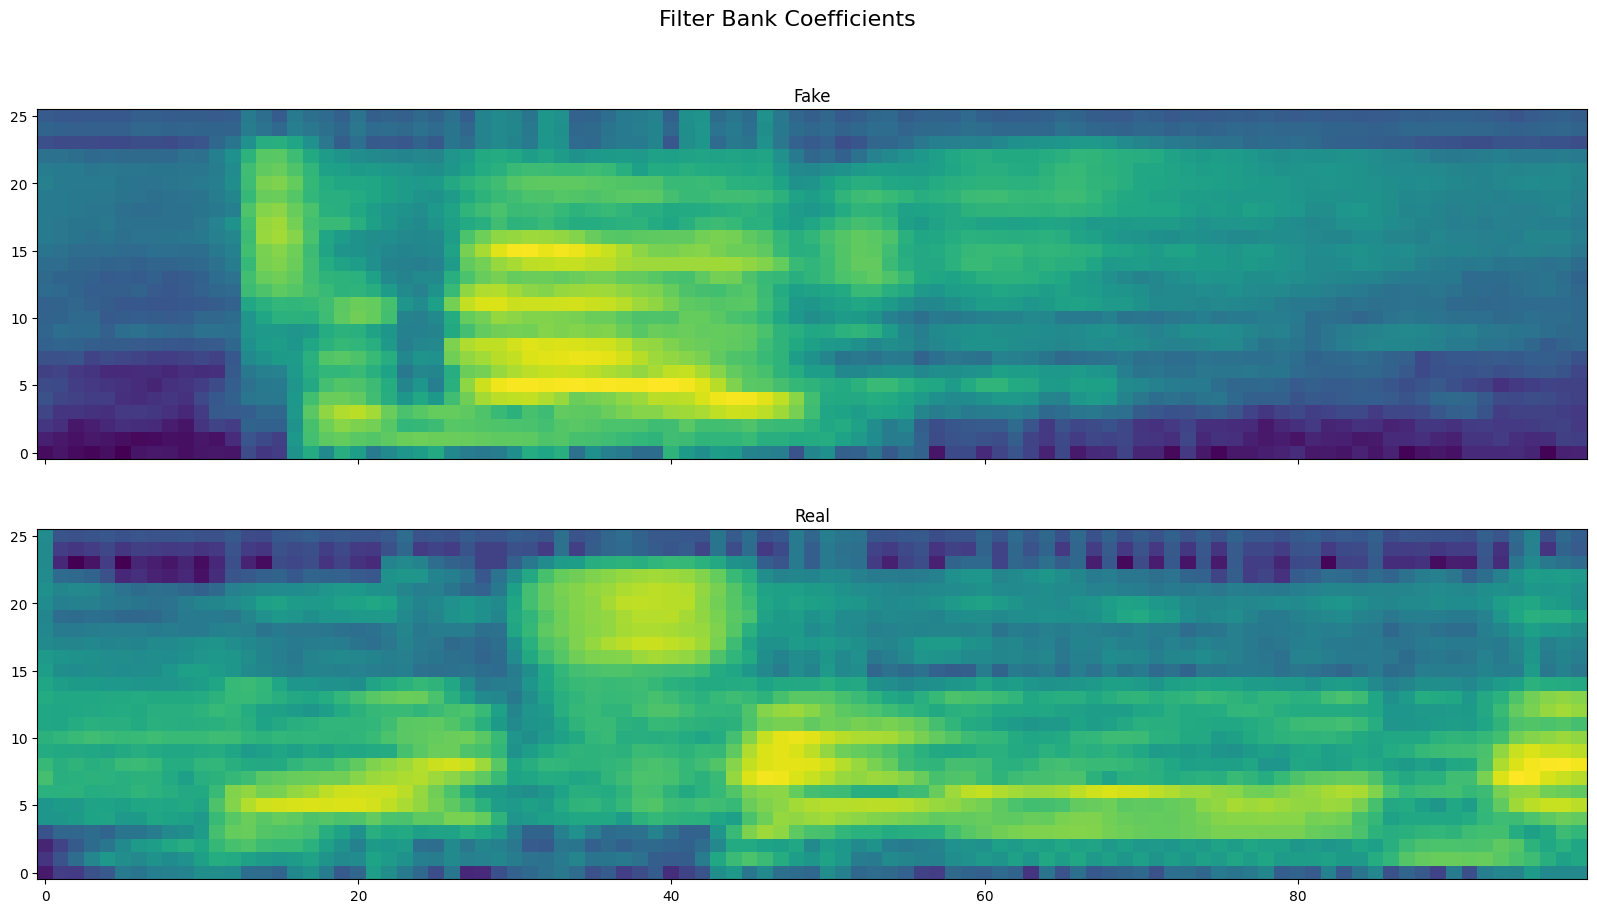

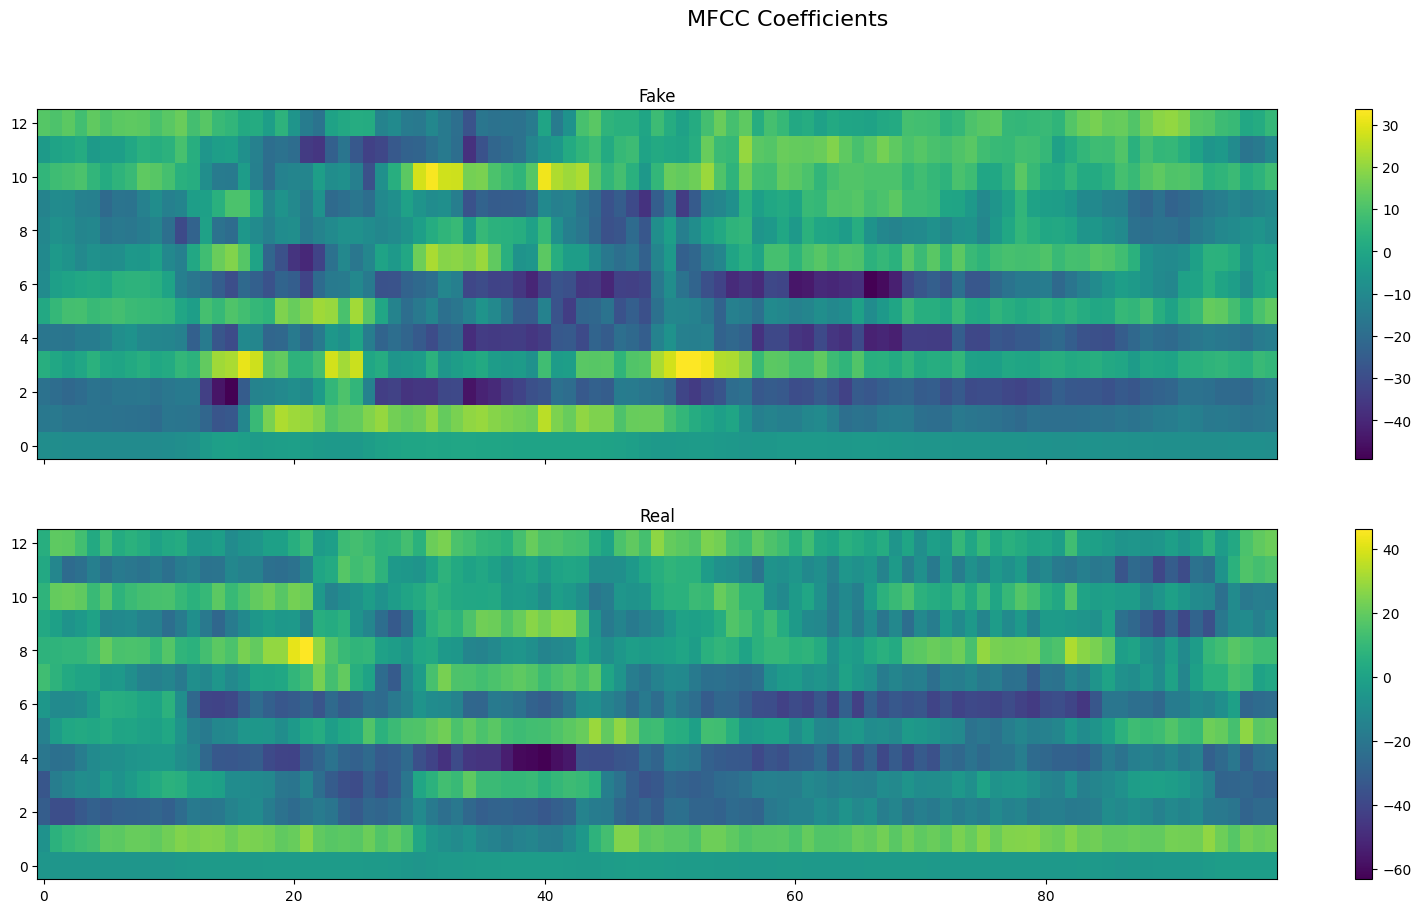

In [9]:
def envelope(y, rate, threashold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean>threashold:
            mask.append(True)
        else:
            mask.append(False)
    return mask    

for c in classes:
    wav_file = speech_df[speech_df['Label'] == c].iloc[0]['Filename']
    
    if c == 'Real':
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/{wav_file}"
    else:
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/{wav_file}"
    
    print(f"Label: {c}, Filename: {wav_file}, File path: {file_path}")
    
    try:
        signal, rate = lb.load(file_path, sr=44100)
        mask = envelope(signal,rate, 0.0005)
        signal = signal[mask]
        signals[c] = signal
        fft[c] = calc_fft(signal, rate)

        bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
        fbank[c] = bank
        mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
        mfccs[c] = mel
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

print("Signals dictionary:", signals)
print("FFT dictionary:", fft)
print("Filter Bank dictionary:", fbank)
print('Mfccs dictionary:',mfccs)

plot_signals(signals)
plot_fft(fft)
plot_fbank(fbank)
plot_mfccs(mfccs)
    

Label: Fake, Filename: Obama-to-Biden.wav, File path: /Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav
Label: Real, Filename: biden-original.wav, File path: /Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/biden-original.wav


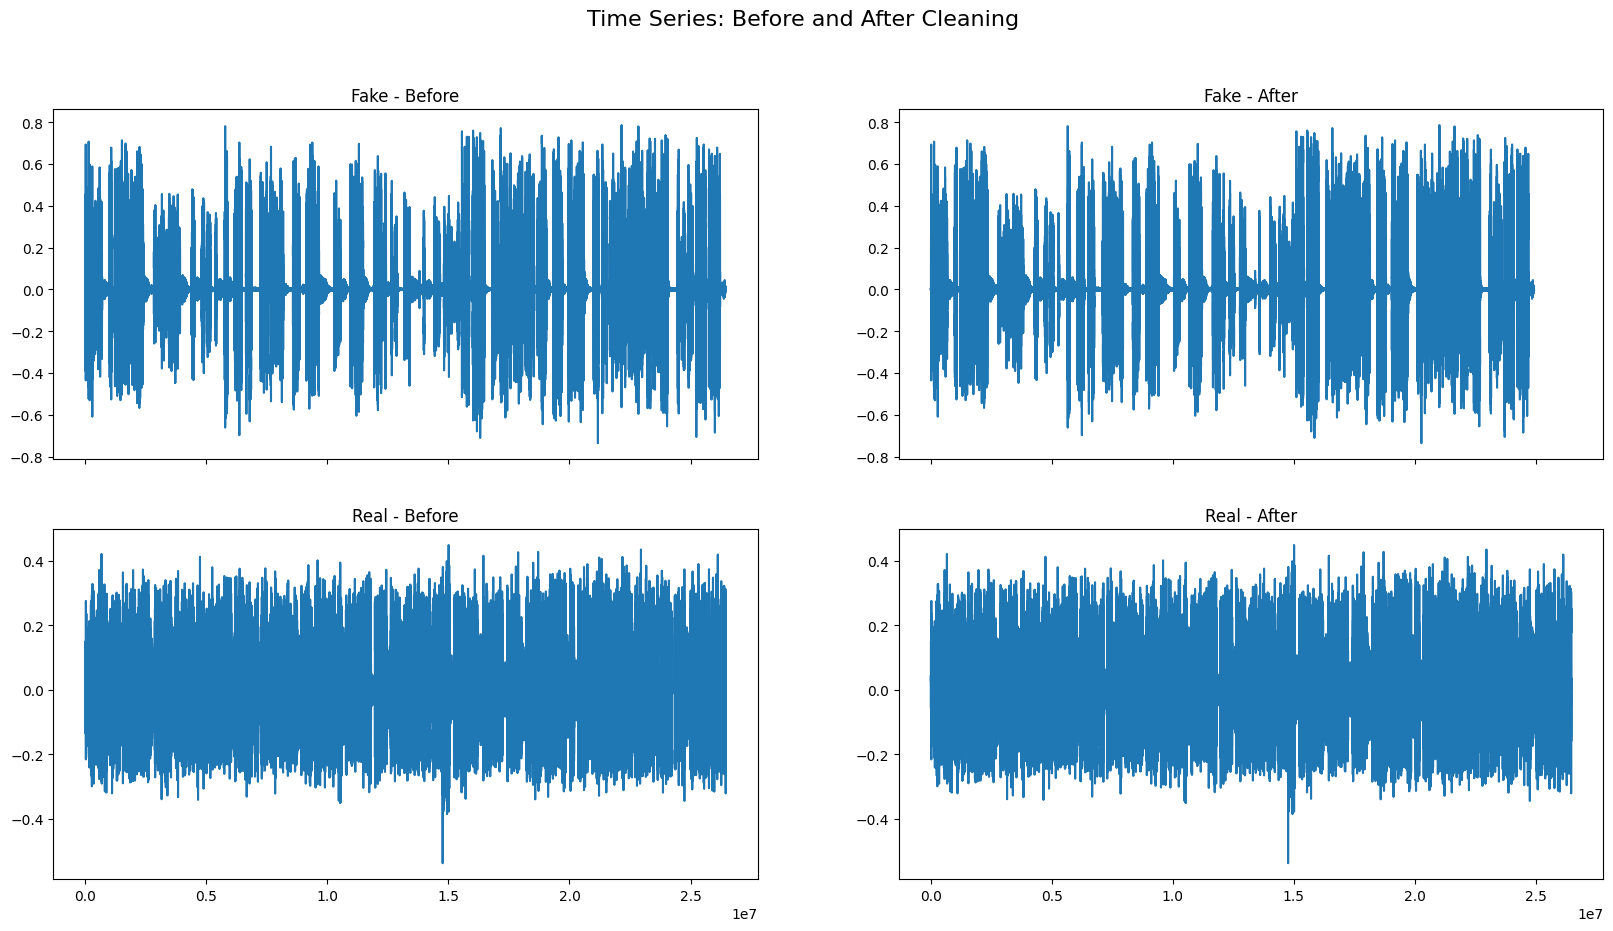

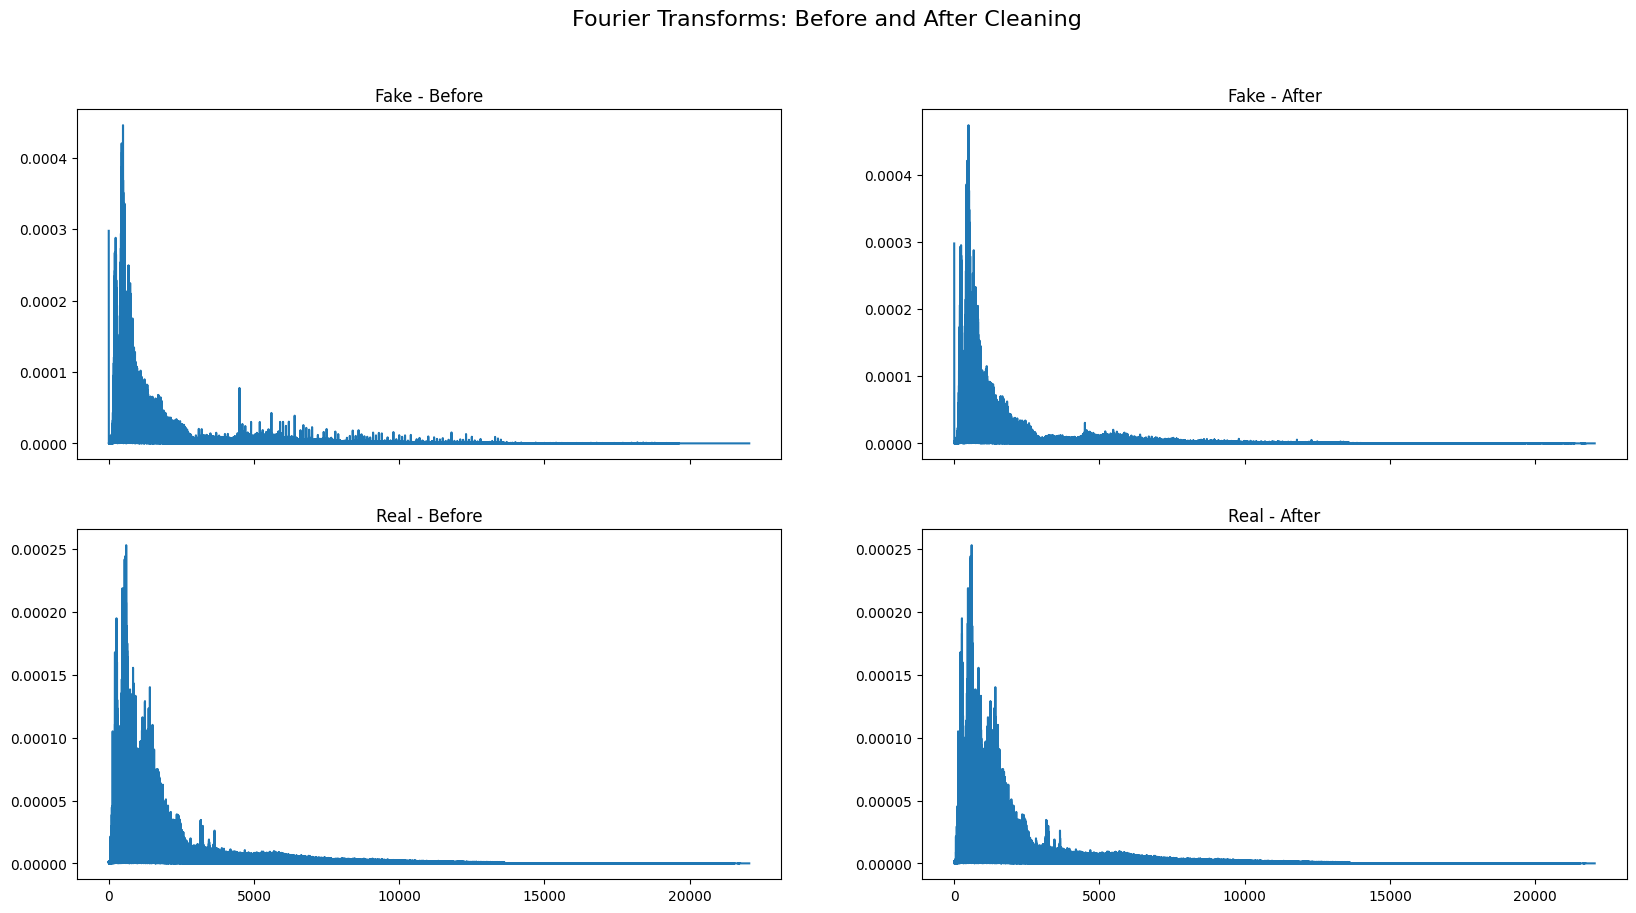

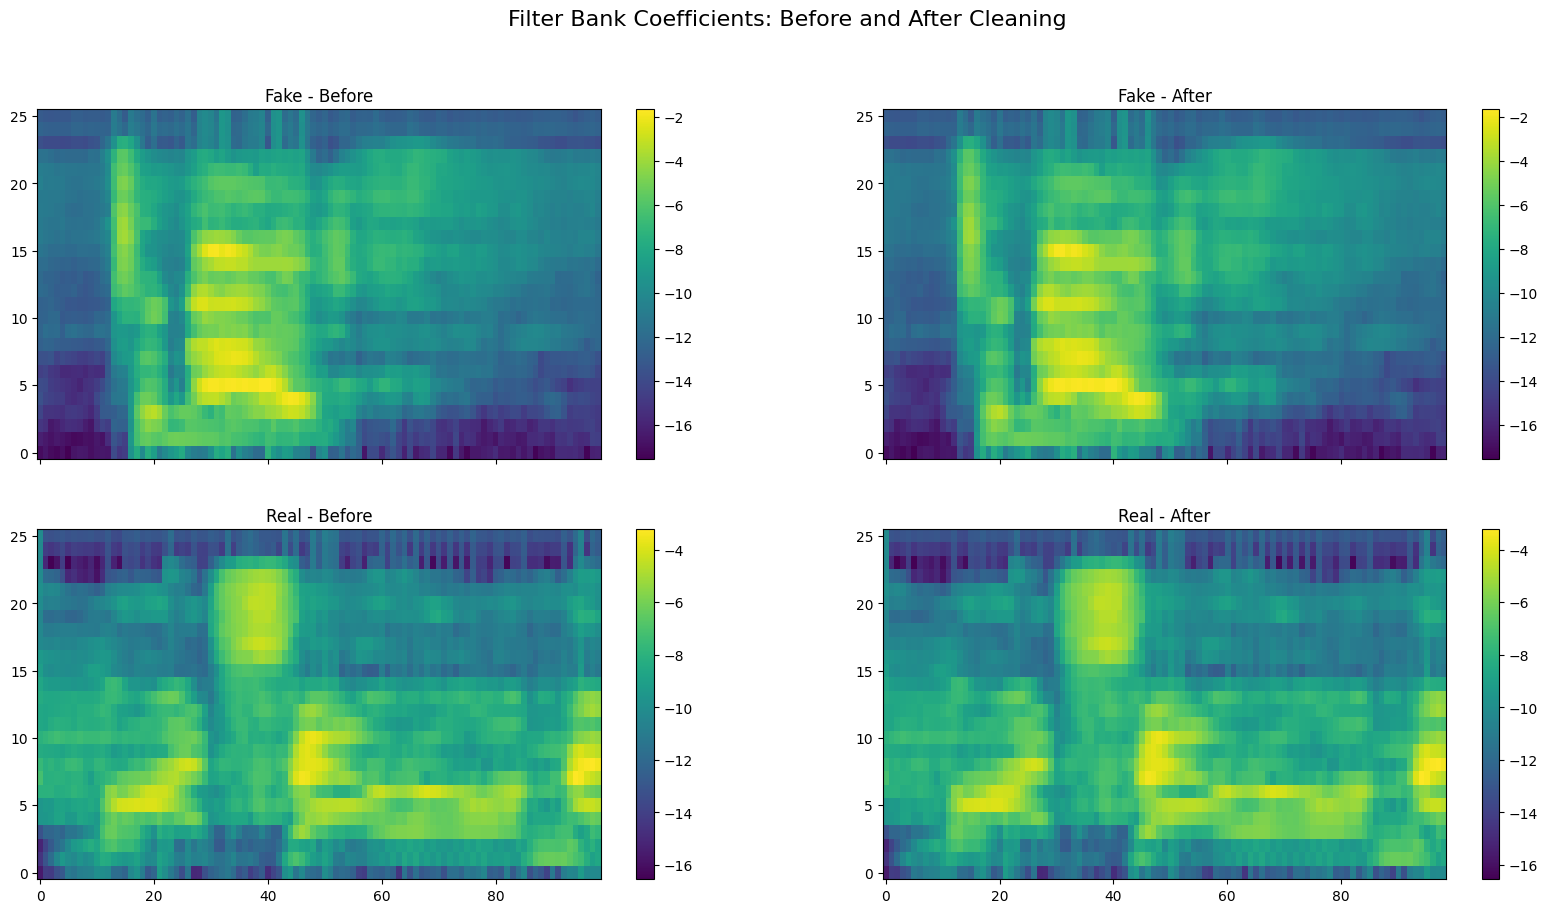

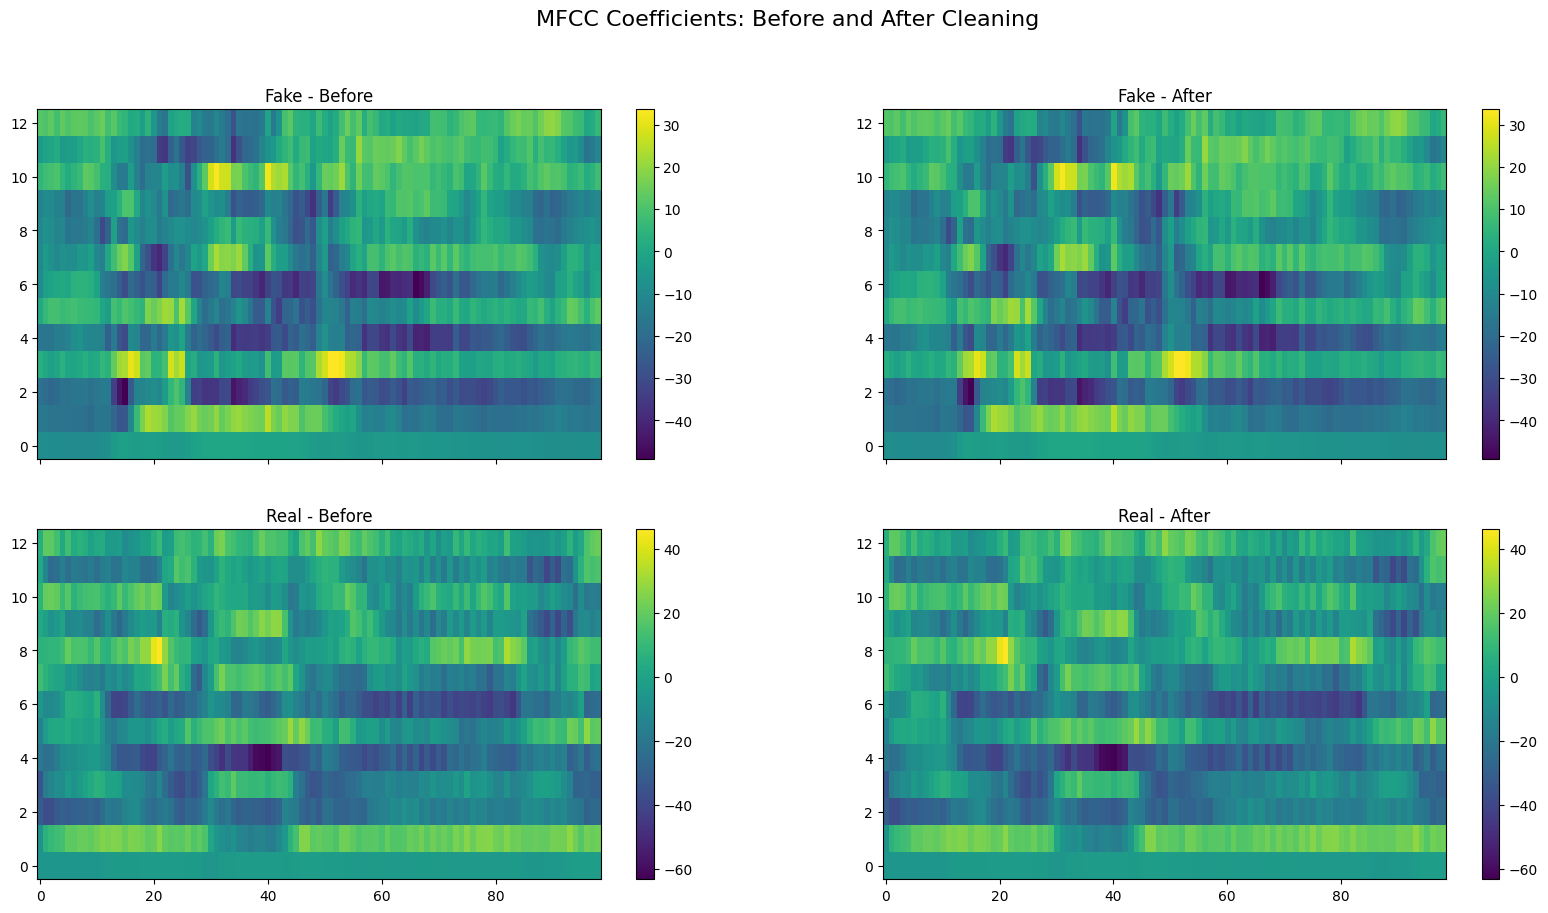

In [10]:

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y) / n)
    return (Y, freq)

def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        mask.append(mean > threshold)
    return mask

def plot_signals(signals_before, signals_after):
    fig, axes = plt.subplots(nrows=len(signals_before), ncols=2, figsize=(20, 10), sharex=True)
    fig.suptitle('Time Series: Before and After Cleaning', size=16)
    for i, (label, signal) in enumerate(signals_before.items()):
        axes[i, 0].set_title(f"{label} - Before")
        axes[i, 0].plot(signal)
        axes[i, 1].set_title(f"{label} - After")
        axes[i, 1].plot(signals_after[label])
    plt.show()

def plot_fft(fft_before, fft_after):
    fig, axes = plt.subplots(nrows=len(fft_before), ncols=2, figsize=(20, 10), sharex=True)
    fig.suptitle('Fourier Transforms: Before and After Cleaning', size=16)
    for i, (label, (Y, freq)) in enumerate(fft_before.items()):
        axes[i, 0].set_title(f"{label} - Before")
        axes[i, 0].plot(freq, Y)
        axes[i, 1].set_title(f"{label} - After")
        Y_after, freq_after = fft_after[label]
        axes[i, 1].plot(freq_after, Y_after)
    plt.show()

def plot_fbank(fbank_before, fbank_after):
    fig, axes = plt.subplots(nrows=len(fbank_before), ncols=2, figsize=(20, 10), sharex=True)
    fig.suptitle('Filter Bank Coefficients: Before and After Cleaning', size=16)
    for i, (label, bank) in enumerate(fbank_before.items()):
        axes[i, 0].set_title(f"{label} - Before")
        im = axes[i, 0].imshow(bank, aspect='auto', origin='lower')
        fig.colorbar(im, ax=axes[i, 0])
        axes[i, 1].set_title(f"{label} - After")
        im = axes[i, 1].imshow(fbank_after[label], aspect='auto', origin='lower')
        fig.colorbar(im, ax=axes[i, 1])
    plt.show()

def plot_mfccs(mfccs_before, mfccs_after):
    fig, axes = plt.subplots(nrows=len(mfccs_before), ncols=2, figsize=(20, 10), sharex=True)
    fig.suptitle('MFCC Coefficients: Before and After Cleaning', size=16)
    for i, (label, mfcc) in enumerate(mfccs_before.items()):
        axes[i, 0].set_title(f"{label} - Before")
        im = axes[i, 0].imshow(mfcc, aspect='auto', origin='lower')
        fig.colorbar(im, ax=axes[i, 0])
        axes[i, 1].set_title(f"{label} - After")
        im = axes[i, 1].imshow(mfccs_after[label], aspect='auto', origin='lower')
        fig.colorbar(im, ax=axes[i, 1])
    plt.show()

# Before Cleaning
signals_before = {}
fft_before = {}
fbank_before = {}
mfccs_before = {}

# After Cleaning
signals_after = {}
fft_after = {}
fbank_after = {}
mfccs_after = {}

# Ensure that the 'filename' column contains strings
speech_df['Filename'] = speech_df['Filename'].astype(str)

classes = list(np.unique(speech_df['Label']))
class_dist = speech_df.groupby(['Label'])['duration_minutes'].mean()

for c in classes:
    wav_file = speech_df[speech_df['Label'] == c].iloc[0]['Filename']
    
    if c == 'Real':
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/{wav_file}"
    else:
        file_path = f"/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/FAKE/{wav_file}"
    
    print(f"Label: {c}, Filename: {wav_file}, File path: {file_path}")
    
    try:
        # Load original signal
        signal, rate = lb.load(file_path, sr=44100)
        signals_before[c] = signal
        fft_before[c] = calc_fft(signal, rate)

        bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
        fbank_before[c] = bank
        mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
        mfccs_before[c] = mel

        # Load cleaned signal
        mask = envelope(signal, rate, 0.0005)
        signal_clean = signal[mask]
        signals_after[c] = signal_clean
        fft_after[c] = calc_fft(signal_clean, rate)

        bank = logfbank(signal_clean[:rate], rate, nfilt=26, nfft=1103).T
        fbank_after[c] = bank
        mel = mfcc(signal_clean[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
        mfccs_after[c] = mel
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

plot_signals(signals_before, signals_after)
plot_fft(fft_before, fft_after)
plot_fbank(fbank_before, fbank_after)
plot_mfccs(mfccs_before, mfccs_after)


## Read CSV and Label Distribution

In [11]:
dataset= pd.read_csv("/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/DATASET-balanced.csv")
dataset

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11773,0.435426,0.025303,2772.575031,2728.757601,4998.670213,0.074323,-342.309753,144.490418,-79.272942,8.890874,...,-17.982819,-7.831161,-1.127167,-7.669674,-0.653850,-8.037575,-2.671002,-4.483765,-3.355975,REAL
11774,0.454611,0.070578,1029.274601,1519.231563,1922.927486,0.026553,-332.230408,202.603012,-0.181929,-2.146542,...,-2.018668,-2.705635,-1.589172,-2.938737,-0.972690,-1.706672,-2.796168,2.171270,-1.660128,REAL
11775,0.374432,0.019063,4063.645317,3558.261357,7299.133512,0.110278,-372.149109,92.670235,-29.082432,59.736637,...,-6.628118,-3.827499,-7.287946,-2.899543,-11.508186,-1.296590,-14.325416,-4.405540,-15.869982,REAL
11776,0.410885,0.090499,1124.655596,1553.651133,2065.942806,0.031761,-328.062805,193.557526,6.779151,-1.304731,...,-5.437202,-4.252508,-1.258683,-2.107233,-1.018154,-2.716950,-3.681598,3.811063,3.948419,REAL


In [12]:
dataset['LABEL'].value_counts()

LABEL
FAKE    5889
REAL    5889
Name: count, dtype: int64

That means that we have balanced data 

In [13]:
def get_spectrogram(y: np.ndarray) -> (np.ndarray, int):
    '''
    Compute the spectrogram of an audio signal.

    Parameters:
    y (np.ndarray): Audio time series.

    Returns:
    d (np.ndarray): Spectrogram of the audio signal, represented in decibels (dB).
    shape (tuple): Shape of the spectrogram (number of frequency bins, number of time frames).
    '''
    
    d = lb.stft(y)
    ad = lb.amplitude_to_db(np.abs(d), ref=np.max)
    
    return ad, ad.shape 

def plot_spectrogram(s: np.ndarray, sr: int = 22050, size: tuple=(8, 4), title: str = "Spectrogram of the Audio"):
    '''
    Plot a spectrogram.

    Parameters:
    s (np.ndarray): Spectrogram to plot. This should be a 2D array where the rows correspond to frequency bins and the columns correspond to time frames.
    sr (int, optional): Sampling rate of the audio. Default is 22050 Hz.
    size (tuple, optional): Size of the plot as (width, height). Default is (8, 4).
    title (str, optional): Title of the plot. Default is "Spectrogram of the Audio".
    '''
    
    plt.figure(figsize=size)
    lb.display.specshow(s, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

In [14]:
def get_mel_spectrogram(y: np.ndarray, sr: int = 22050, n_mels: int = 128) -> (np.ndarray, int):
    '''
    Compute a Mel spectrogram from an audio signal.

    Parameters:
    y (np.ndarray): Audio time series.
    sr (int): Sampling rate of `y`. 
    n_mels (int): Number of Mel bands to generate. 

    Returns:
    mel_spectrogram (np.ndarray): 2D array representing the Mel spectrogram.
    shape (tuple): Shape of the Mel spectrogram (number of Mel bands, number of frames).
    ''' 
    ms = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    m = lb.power_to_db(ms,ref=np.max) 
    
    return m, m.shape

def plot_mel_spectrogram(m: np.ndarray, sr: int = 22050, size: tuple = (8, 4), title: str = "Mel Spectrogram of Audio"):
    '''
    Plot a Mel spectrogram.

    Parameters:
    s (np.ndarray): Mel spectrogram to plot. 
    sr (int, optional): Sampling rate of the audio. Default is 22050 Hz.
    size (tuple, optional): Size of the plot as (width, height). Default is (8, 4).
    title (str, optional): Title of the plot. Default is "Mel Spectrogram of Audio".
    '''
    
    plt.figure(figsize=size)
    lb.display.specshow(m, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


In [15]:
a, sr = lb.load(real_audio[1])
print(real_audio[1])

/Users/antzelinamoysidou/Desktop/libraries/KAGGLE/AUDIO/REAL/linus-original.wav


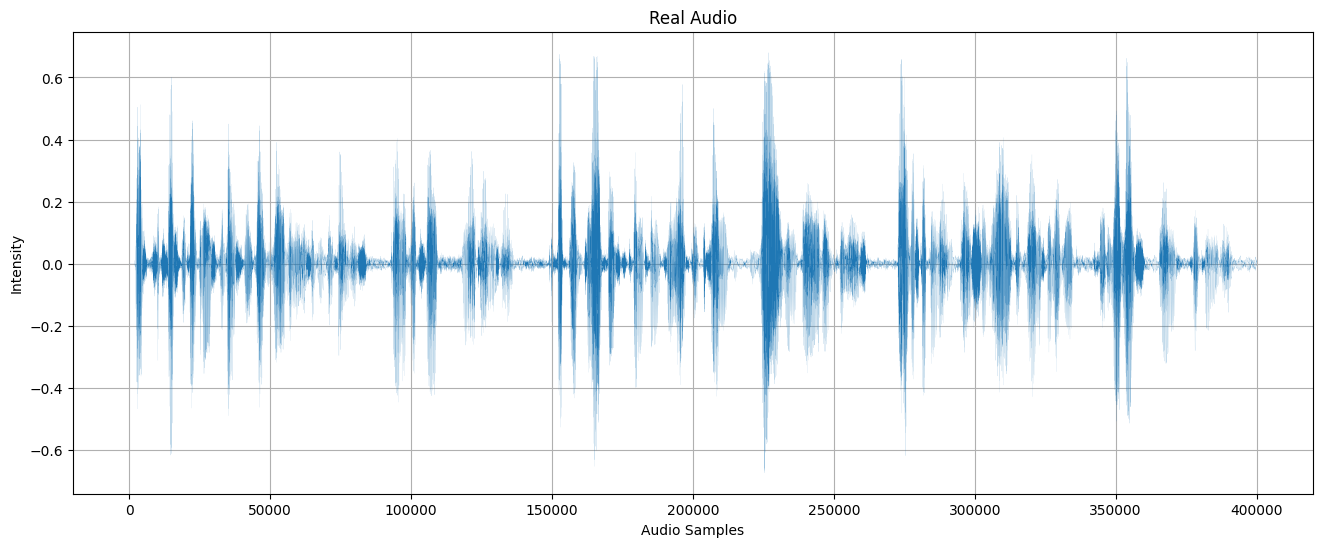

In [16]:
b = a[:400_000]

plt.figure(figsize=(16, 6))
plt.plot(b, lw=0.05)
plt.title("Real Audio")
plt.xlabel("Audio Samples")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()

Dimension of spectrogram: (1025, 782)


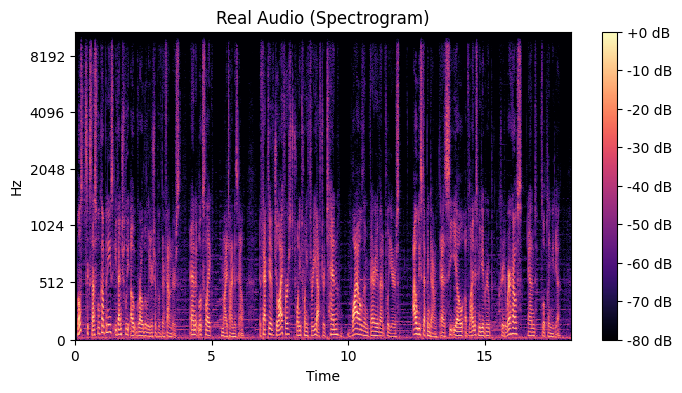

Dimension of mel spectrogram: (512, 782)


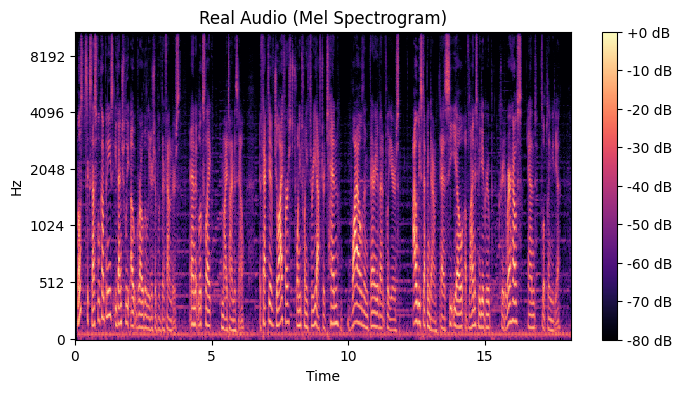

In [17]:
s1, s1_shape = get_spectrogram(y=b)
print(f"Dimension of spectrogram: {s1_shape}")

plot_spectrogram(s1, title="Real Audio (Spectrogram)")

m1, m1_shape = get_mel_spectrogram(y=b, n_mels=512)
print(f"Dimension of mel spectrogram: {m1_shape}")

plot_mel_spectrogram(m1, title="Real Audio (Mel Spectrogram)")